<a href="https://colab.research.google.com/github/katarinagresova/XAI_MALTAomics23/blob/dev/Decoy_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating drop of performance in neural networks

Interpretation techniques can be an useful tools in Deep Neural Network development. We can check if our network is focusing on parts of the data that we would expect it to focus. Or we can even look for biases and other problems in our data.

This notebook have beem adapted from the *Structure and Interpretation of Deep Networks* Deep Learning lab practicum, [lab 1](http://sidn.csail.mit.edu/).



# 1. Setup

In [ ]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:
# Download the dataset (Only necessary for colab)
import os
from urllib.request import urlretrieve
if not os.path.exists('decoy-mnist.npz'):
    urlretrieve('https://github.com/SIDN-IAP/intro-lab/blob/master/decoy-mnist.npz?raw=true', 'decoy-mnist.npz')

# 2. Load and visualize the dataset

In this notebook, we'll introduce some basic concepts in interpretable machine learning through a short series of exerises on the "Decoy MNIST" dataset adapted from [this paper](https://arxiv.org/pdf/1703.03717.pdf).

In [ ]:
# Load the Decoy MNIST dataset
cached = np.load('./decoy-mnist.npz')
arrays = [cached[f] for f in sorted(cached.files)]
X_train, y_train, X_val, y_val, X_test, y_test = arrays

# Verify we get 50000/10000/10000 x 784
print(X_train.shape, X_val.shape, X_test.shape)

(50000, 784) (10000, 784) (10000, 784)


Decoy MNIST is a version of the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/) that has been modified to include a special color swatch in a random corner of the image. In the training (n=50000) and validation (n=10000) sets, the shade of this color swatch corresponds exactly to the digit label, while in the test set, the shade is chosen randomly:

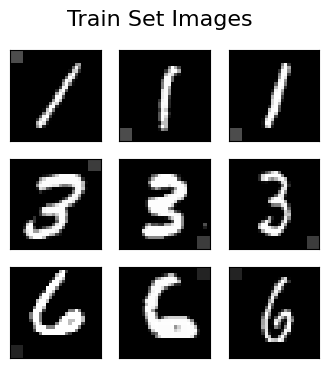

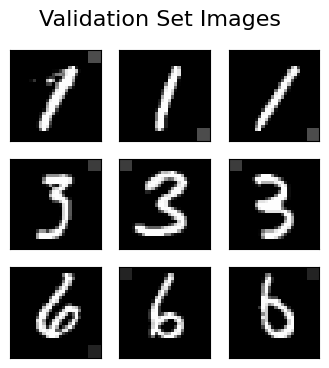

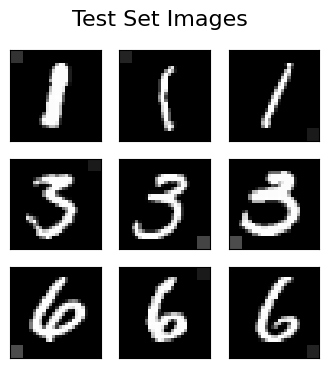

In [ ]:
# Plot some examples from the training / validation / test sets:

def random_digits_matching(digit, X, y):
    idx = np.argwhere(y == digit)[:,0]
    np.random.shuffle(idx)
    return X[idx]

def plot_digit(x):
    """Plot 2D image in black and white."""
    lim = np.abs(x).max()
    plt.imshow(x.reshape(-28,28), cmap='gray')
    plt.xticks([])
    plt.yticks([])

for split, X, y in [('Train', X_train, y_train), ('Validation', X_val, y_val), ('Test', X_test, y_test)]:
    fig = plt.figure(figsize=(4,4))
    fig.suptitle(split + " Set Images", fontsize=16)
    plot = 0
    for digit in [1, 3, 6]:
        images = random_digits_matching(digit, X, y)
        for i in range(3):
            plot += 1
            plt.subplot(3,3,plot)
            plot_digit(images[i])
    plt.show()

By adding this faint color swatch, we've deliberately introduced what can either be seen as a _redundancy_ (in that we have two conceptually independent ways of predicting the label during training) or an _incompleteness_ (in that the training images and labels now actually provide us **less** information about the right function to learn).

We'll explore the consequences of this redundancy / incompleteness below.

# 3. Define neural network class

To test out how models react to redundancy, we first need to define at least one type of model. For this lab, we'll focus on a relatively simple 784x50x50x10 fully-connected neural network (to minimize training time).

In [ ]:
def one_hot(y):
    """Convert Nx1 flat list of digits to Nx10 'one-hot' encoded array."""
    values = np.arange(10)
    return np.array([values == v for v in y]).astype(int)

class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        """Initialize a 2-hidden-layer fully connected neural network w/ ReLU activations."""
        super(SimpleNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        """Forward pass of the neural network, mapping input tensors -> unnormalized digit logits."""
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

    def predict(self, x):
        """Map numpy input images to digit predictions"""
        images = torch.Tensor(x)
        logits = self(images)
        return np.argmax(logits.data.numpy(), axis=1)

    def accuracy(self, x, y):
        """Compute accuracy of predictions."""
        return (self.predict(x) == y).mean()

    def input_grads(self, x):
        """Map numpy input images to saliency maps (as -logprob input gradients)"""
        images = Variable(torch.Tensor(x), requires_grad=True)
        logits = self(images) # pass images through the network
        neglogps = -F.log_softmax(logits, 1) # compute negative log-probs for each digit
        neglogps.sum().backward() # sum to get a scalar quantity dependent on all outputs
        return images.grad.data.numpy() # return the input gradient

    def fit(self, X, y, lr=0.001, weight_decay=0.005, epochs=None, batch_size=256):
        """Fit the neural network on inputs `X` and labels `y`
        for `epochs` passes through the dataset in `batch_size` increments
        with `lr` learning rate and the provided L2 `weight_decay`."""

        # Train for about 2000 steps, by default
        if epochs is None:
          epochs = (2000 * batch_size) // len(X)

        # Use cross-entropy + weight decay loss and Adam
        loss_func = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Convert numpy dataset to tensors
        dataset = data.TensorDataset(torch.Tensor(X), torch.Tensor(one_hot(y)))
        loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Main training loop
        step = 0
        for epoch in range(epochs):
            for images, labels in loader:
                optimizer.zero_grad()
                outputs = self(Variable(images))
                loss = loss_func(outputs, Variable(labels))
                loss.backward()
                optimizer.step()
                if step % 200 == 0:
                  print('Step {}, Loss: {:.4f}'.format(step, loss.data))
                step += 1

# 4. Train network on training data

Let's fit our model on the data (with a bit of weight decay):

In [ ]:
net = SimpleNeuralNetwork()
net.fit(X_train, y_train, lr=0.001, weight_decay=0.005)

Step 0, Loss: 2.6177
Step 200, Loss: 0.0354
Step 400, Loss: 0.0252
Step 600, Loss: 0.0272
Step 800, Loss: 0.0190
Step 1000, Loss: 0.0170
Step 1200, Loss: 0.0202
Step 1400, Loss: 0.0143
Step 1600, Loss: 0.0160
Step 1800, Loss: 0.0182


# 5. Examine validation and test accuracy

Now that we've fit our model, we can look at its accuracy:

In [ ]:
print("Validation accuracy:", net.accuracy(X_val, y_val))

Validation accuracy: 0.9781


In [ ]:
print("Test accuracy:", net.accuracy(X_test, y_test))

Test accuracy: 0.7611


You should notice that test accuracy, while still well above random guessing, is significantly lower than validation accuracy.

This is likely because the testing dataset contains two conflicting rules: the digit image and the color swatch. The fact that test accuracy is (likely) closer to 1 than 1/10 suggests the model is more reliant on the digit image than the color swatch, but it's still clearly confused.

Let's try to investigate what's going on using a saliency method:

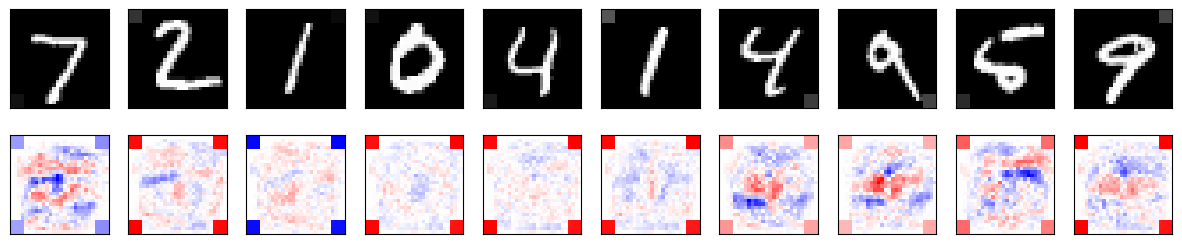

In [ ]:
# Compute input gradients, a basic saliency method
# (we'll cover this in the next section in more detail)
grads = net.input_grads(X_test)

# Plot them as heatmaps
def plot_grad(x):
    """Plot gradient as heatmap, where red = positive, blue = negative, and white = 0."""
    lim = np.abs(x).max()
    plt.imshow(x.reshape(-28,28), cmap='bwr', vmin=-lim, vmax=lim)
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(15,3))
for i in range(10):
  plt.subplot(2,10,i+1)
  plot_digit(X_test[i])
for i in range(10):
  plt.subplot(2,10,i+11)
  plot_grad(grads[i])

These plots highlight areas where the model is locally sensitive to small changes.

**The main takeaway here is that the model's outputs are very sensitive both to changes in the corner pixels and to changes in the main digit region, suggesting a reasonable dependence on both.**

If you're curious about how to understand _exactly_ what these plots mean, you're not the only one -- saliency maps are notorious for being difficult to interpret, and we'll cover these issues in later classes. However, for completeness, here's what these plots literally mean:
- whitening the image at red areas increases the model's confidence in its prediction
- whitening the image at blue areas decreases the model's confidence in its prediction
- the degree of redness or blueness quantifies the magnitude of this increase or decrease


# Exercise 1: Train a new neural network

Create a second neural network, except this time, `fit` it on `X_test` / `y_test` and then evaluate its performance / visualize its gradients on the training or validation set

In [ ]:
# Initialize and fit network

In [ ]:
# Compute accuracies

In [ ]:
# Plot gradients

Can you see any difference in behavior between this new model and the net you fit on the original training set, either in its accuracy statistics or its saliency maps? What to these quantitative values (accuracy + gradients) tell you about its qualitative differences?

# Exercise 2: Explore the effect of weight decay at `0.0`, `0.001`, `0.01`, `0.1`, and `1.0`

In our `fit` method, we pass in `weight_decay` value of `0.005`. This means that during training, we're minimizing not just the cross-entropy loss (i.e. prediction error), but also the complexity of our model --- as quantifiied by `0.005` times the sum of the squares of its weights.

In this example, we'd like you to test out the effect of the weight decay on the model's sensitivity to the color swatch and on its saliency maps.

In [ ]:
weight_decays = [0.0, 0.001, 0.01, 0.1, 1.0]

In [ ]:
# Fit models for each weight decay value

In [ ]:
# Print all of their validation and test accuracies

In [ ]:
# Plot each model's input gradients for the first 10 test examples

What do you notice about the different models? Does the gap between validation and test accuracy change as a function of weight decay? Does the validation accuracy of the model change? How about the smoothness of the saliency maps?  What, if anything, do you feel you can _interpret_ about the differences between each of the models?